In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from torchvision.ops import SqueezeExcitation
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

### Loading data

In [2]:
keys_s = '0123456789abcdefghijklmnopqrstuvwxyz'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [3]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

def convert_to_df(AUDIO_FILE):
    for i, File in enumerate(keys):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)
    return df, sample_rate 

In [4]:
data_frame, sr = convert_to_df("../dataset/Zoom/")

print(data_frame.head())
print(data_frame.info())

  Key                                               File
0   0  [[tensor(-6.1035e-05), tensor(-6.1035e-05), te...
1   0  [[tensor(0.), tensor(-3.0518e-05), tensor(-3.0...
2   0  [[tensor(3.0518e-05), tensor(3.0518e-05), tens...
3   0  [[tensor(-0.0002), tensor(-0.0002), tensor(-0....
4   0  [[tensor(6.1035e-05), tensor(6.1035e-05), tens...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    object
 1   File    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
None


In [5]:
train_set, tmp_set = train_test_split(data_frame, test_size=0.3)
val_set, test_set = train_test_split(tmp_set, test_size=0.33)

print("Sample rate:", sr)
print(len(train_set), len(val_set), len(test_set))

Sample rate: 32000
630 180 90


### Data augmentation setup

In [6]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=2048, win_length=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])
        
train_set = MyDataset(train_set, aug = aug)
val_set = MyDataset(val_set, transform = transform)
test_set = MyDataset(test_set, transform = transform)

### Training set image (augmented vs non-augmented)

torch.Size([64, 64])


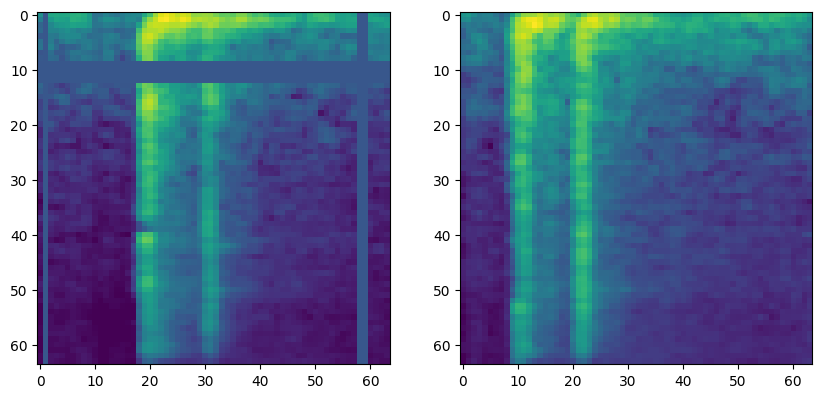

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_set[0][0][0], cmap='viridis')
ax2.imshow(val_set[0][0][0], cmap='viridis')
print(train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [8]:
print("number of classes:", len(np.unique(data_frame['Key'])))

number of classes: 36


### CoAtNet (Model)

In [9]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [10]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [11]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [12]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [13]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [14]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [15]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [16]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [18]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [19]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

c:\Users\user\miniconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

### Training

In [22]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [23]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [24]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [25]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [26]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

Epoch [1/1100], Loss: 13.603354454040527, Accuracy: 0.0380952380952381 Correct: 24 Total: 630 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.044444444444444446 Validation loss: 13.899195671081543 Correct: 8 Total: 180
Epoch [2/1100], Loss: 11.011100769042969, Accuracy: 0.05396825396825397 Correct: 34 Total: 630 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.07777777777777778 Validation loss: 13.20828628540039 Correct: 14 Total: 180
Epoch [3/1100], Loss: 8.403828620910645, Accuracy: 0.06349206349206349 Correct: 40 Total: 630 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.08888888888888889 Validation loss: 4.6528401374816895 Correct: 16 Total: 180
Epoch [4/1100], Loss: 10.040680885314941, Accuracy: 0.09841269841269841 Correct: 62 Total: 630 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.1111111111111111 Validation loss: 3.1990694999694824 Correct: 20 Total: 180
Epoch [5/1100], Loss: 6.2811675071716

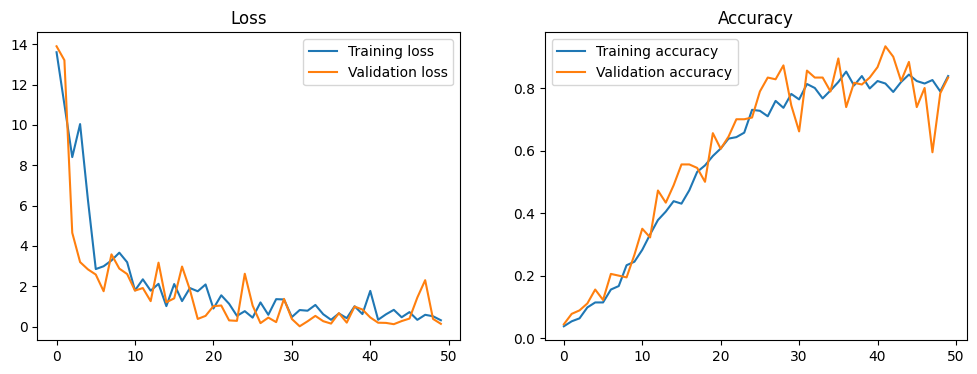

Epoch [51/1100], Loss: 1.1981009244918823, Accuracy: 0.846031746031746 Correct: 533 Total: 630 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.85 Validation loss: 0.10168536007404327 Correct: 153 Total: 180
Epoch [52/1100], Loss: 1.0414162874221802, Accuracy: 0.8126984126984127 Correct: 512 Total: 630 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.8 Validation loss: 0.10030399262905121 Correct: 144 Total: 180
Epoch [53/1100], Loss: 0.5745472311973572, Accuracy: 0.8317460317460318 Correct: 524 Total: 630 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.8833333333333333 Validation loss: 0.045200761407613754 Correct: 159 Total: 180
Epoch [54/1100], Loss: 0.40187475085258484, Accuracy: 0.8746031746031746 Correct: 551 Total: 630 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.8555555555555555 Validation loss: 0.33247900009155273 Correct: 154 Total: 180
Epoch [55/1100], Loss: 0.852308213

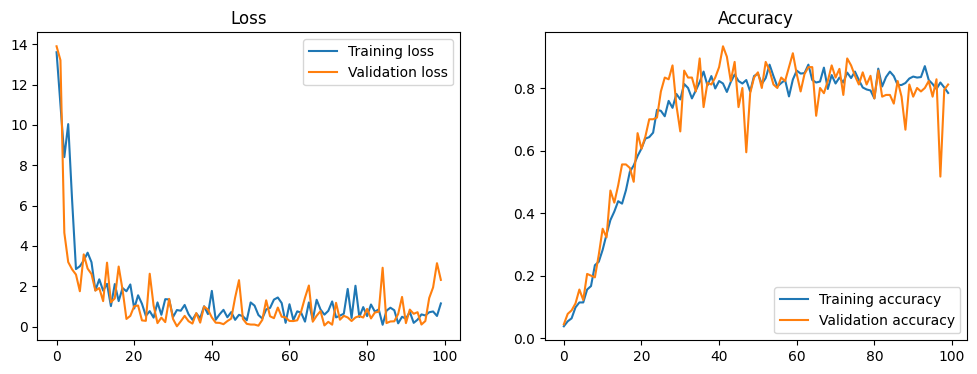

Epoch [101/1100], Loss: 0.8160914778709412, Accuracy: 0.834920634920635 Correct: 526 Total: 630 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.7777777777777778 Validation loss: 0.4766354262828827 Correct: 140 Total: 180
Epoch [102/1100], Loss: 1.142620325088501, Accuracy: 0.8238095238095238 Correct: 519 Total: 630 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.4722222222222222 Validation loss: 0.4491578936576843 Correct: 85 Total: 180
Epoch [103/1100], Loss: 0.734981119632721, Accuracy: 0.8158730158730159 Correct: 514 Total: 630 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.65 Validation loss: 1.3975259065628052 Correct: 117 Total: 180
Epoch [104/1100], Loss: 1.068349838256836, Accuracy: 0.8365079365079365 Correct: 527 Total: 630 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.7722222222222223 Validation loss: 0.8183841705322266 Correct: 139 Total: 180
Epoch [105/1100], Loss: 

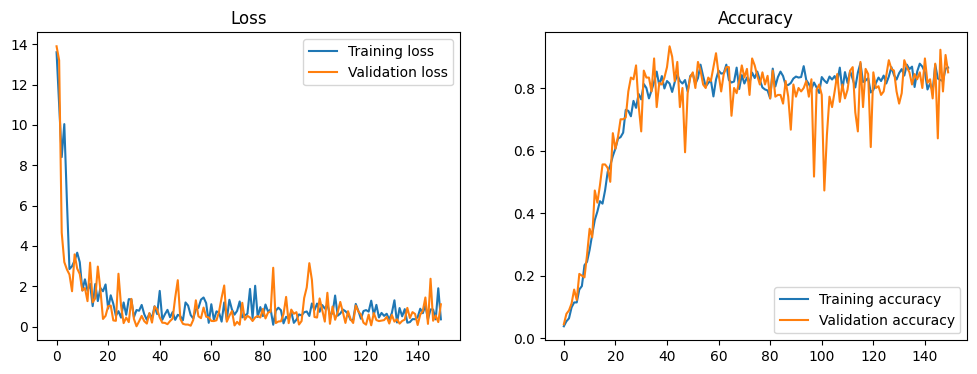

Epoch [151/1100], Loss: 1.0592414140701294, Accuracy: 0.873015873015873 Correct: 550 Total: 630 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.8555555555555555 Validation loss: 0.43430420756340027 Correct: 154 Total: 180
Epoch [152/1100], Loss: 0.5678860545158386, Accuracy: 0.8666666666666667 Correct: 546 Total: 630 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.8722222222222222 Validation loss: 0.16037920117378235 Correct: 157 Total: 180
Epoch [153/1100], Loss: 0.7292957901954651, Accuracy: 0.8587301587301587 Correct: 541 Total: 630 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.8166666666666667 Validation loss: 0.4922564625740051 Correct: 147 Total: 180
Epoch [154/1100], Loss: 0.6934401988983154, Accuracy: 0.861904761904762 Correct: 543 Total: 630 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8277777777777777 Validation loss: 0.14071734249591827 Correct: 149 Total: 180
Epoch

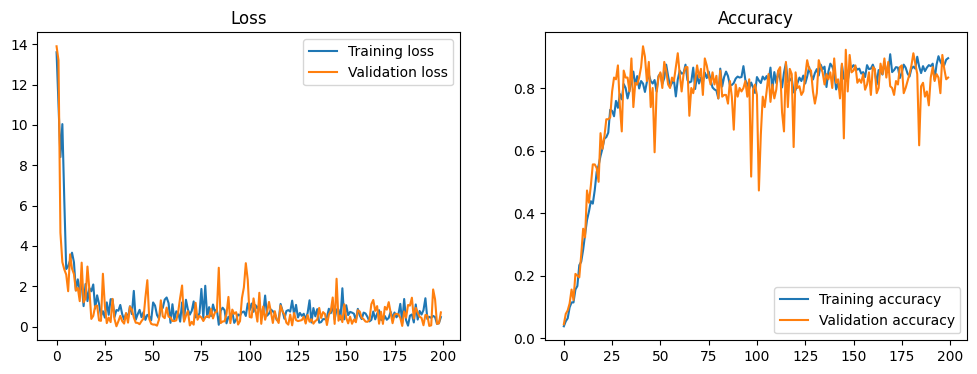

Epoch [201/1100], Loss: 0.2445554882287979, Accuracy: 0.8793650793650793 Correct: 554 Total: 630 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8722222222222222 Validation loss: 1.5386278629302979 Correct: 157 Total: 180
Epoch [202/1100], Loss: 0.3286402225494385, Accuracy: 0.8825396825396825 Correct: 556 Total: 630 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.8388888888888889 Validation loss: 0.47938641905784607 Correct: 151 Total: 180
Epoch [203/1100], Loss: 0.556786060333252, Accuracy: 0.8412698412698413 Correct: 530 Total: 630 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8555555555555555 Validation loss: 0.08626578748226166 Correct: 154 Total: 180
Epoch [204/1100], Loss: 0.3899918794631958, Accuracy: 0.8873015873015873 Correct: 559 Total: 630 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8611111111111112 Validation loss: 0.6424365043640137 Correct: 155 Total: 180
Epo

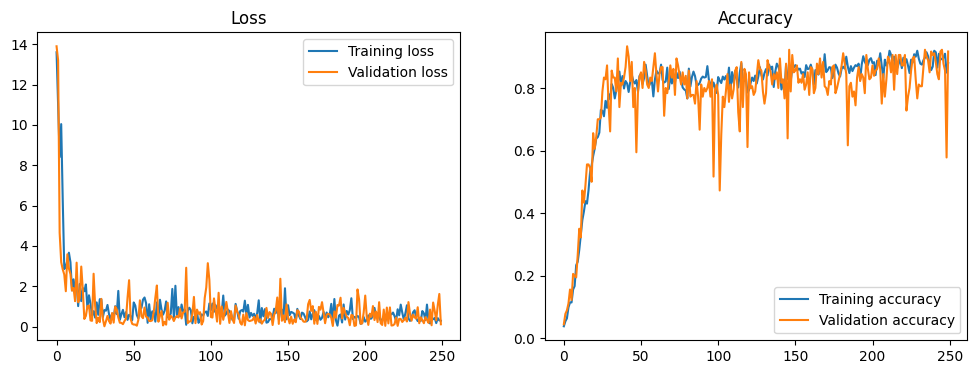

Epoch [251/1100], Loss: 0.14832556247711182, Accuracy: 0.9031746031746032 Correct: 569 Total: 630 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8444444444444444 Validation loss: 1.0359796285629272 Correct: 152 Total: 180
Epoch [252/1100], Loss: 0.5521449446678162, Accuracy: 0.9015873015873016 Correct: 568 Total: 630 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.8055555555555556 Validation loss: 1.3372597694396973 Correct: 145 Total: 180
Epoch [253/1100], Loss: 2.092941999435425, Accuracy: 0.8603174603174604 Correct: 542 Total: 630 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.75 Validation loss: 0.12848785519599915 Correct: 135 Total: 180
Epoch [254/1100], Loss: 1.0890576839447021, Accuracy: 0.8746031746031746 Correct: 551 Total: 630 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.9 Validation loss: 0.6362740397453308 Correct: 162 Total: 180
Epoch [255/1100], Loss: 0.676211

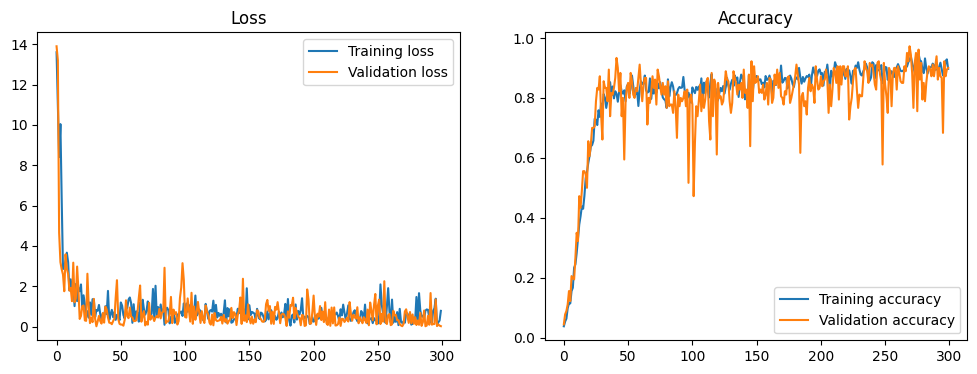

Epoch [301/1100], Loss: 0.5794735550880432, Accuracy: 0.9158730158730158 Correct: 577 Total: 630 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.8666666666666667 Validation loss: 0.12135666608810425 Correct: 156 Total: 180
Epoch [302/1100], Loss: 0.30600202083587646, Accuracy: 0.9142857142857143 Correct: 576 Total: 630 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8944444444444445 Validation loss: 0.2522764801979065 Correct: 161 Total: 180
Epoch [303/1100], Loss: 0.2654581069946289, Accuracy: 0.9079365079365079 Correct: 572 Total: 630 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.9 Validation loss: 0.7660453915596008 Correct: 162 Total: 180
Epoch [304/1100], Loss: 0.24933260679244995, Accuracy: 0.9301587301587302 Correct: 586 Total: 630 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.95 Validation loss: 0.23381945490837097 Correct: 171 Total: 180
Epoch [305/1100], Loss: 0.359

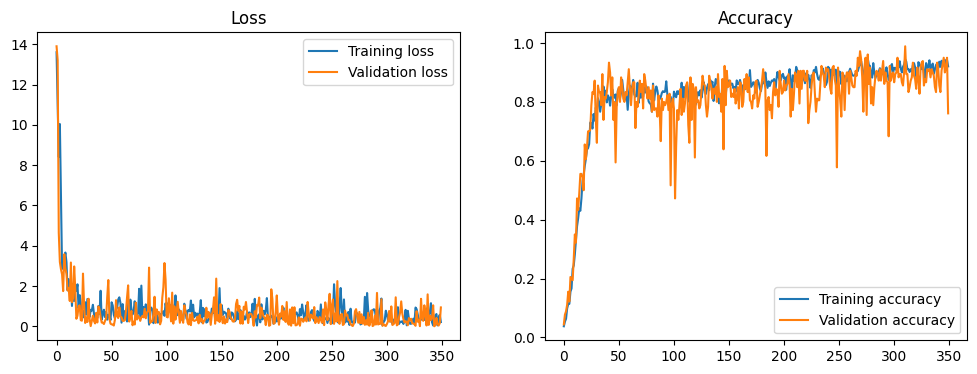

Epoch [351/1100], Loss: 0.5619900226593018, Accuracy: 0.9095238095238095 Correct: 573 Total: 630 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.8444444444444444 Validation loss: 0.4923039376735687 Correct: 152 Total: 180
Epoch [352/1100], Loss: 1.0789551734924316, Accuracy: 0.8984126984126984 Correct: 566 Total: 630 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.9055555555555556 Validation loss: 0.6921843886375427 Correct: 163 Total: 180
Epoch [353/1100], Loss: 0.14017747342586517, Accuracy: 0.9285714285714286 Correct: 585 Total: 630 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.8833333333333333 Validation loss: 0.40292781591415405 Correct: 159 Total: 180
Epoch [354/1100], Loss: 0.6769441962242126, Accuracy: 0.9396825396825397 Correct: 592 Total: 630 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.9166666666666666 Validation loss: 0.1229487806558609 Correct: 165 Total: 180
Epoch

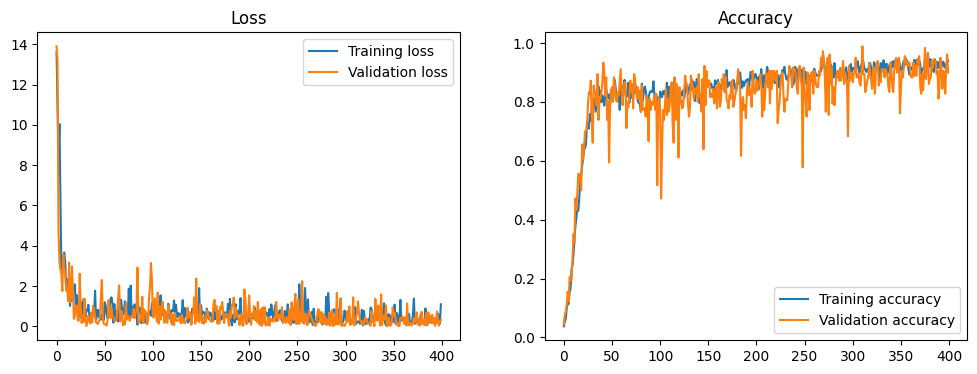

Epoch [401/1100], Loss: 0.0652422308921814, Accuracy: 0.9412698412698413 Correct: 593 Total: 630 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.9388888888888889 Validation loss: 0.021311266347765923 Correct: 169 Total: 180
Epoch [402/1100], Loss: 0.6410966515541077, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.8833333333333333 Validation loss: 0.10524040460586548 Correct: 159 Total: 180
Epoch [403/1100], Loss: 0.14837400615215302, Accuracy: 0.9253968253968254 Correct: 583 Total: 630 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.8222222222222222 Validation loss: 1.0680038928985596 Correct: 148 Total: 180
Epoch [404/1100], Loss: 0.13326603174209595, Accuracy: 0.9428571428571428 Correct: 594 Total: 630 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.85 Validation loss: 0.35362303256988525 Correct: 153 Total: 180
Epoch [405/11

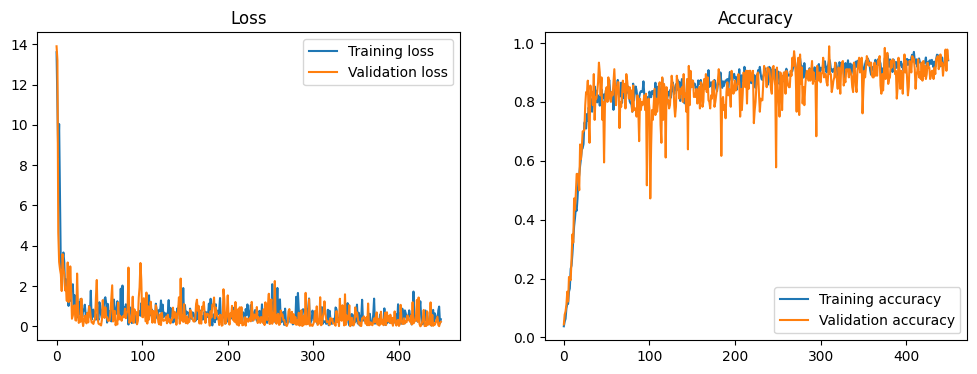

Epoch [451/1100], Loss: 0.508253276348114, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.8833333333333333 Validation loss: 0.044799432158470154 Correct: 159 Total: 180
Epoch [452/1100], Loss: 1.5590251684188843, Accuracy: 0.9301587301587302 Correct: 586 Total: 630 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.95 Validation loss: 0.023358846083283424 Correct: 171 Total: 180
Epoch [453/1100], Loss: 0.30625656247138977, Accuracy: 0.9523809523809523 Correct: 600 Total: 630 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.9444444444444444 Validation loss: 0.7025154232978821 Correct: 170 Total: 180
Epoch [454/1100], Loss: 0.4680980443954468, Accuracy: 0.9428571428571428 Correct: 594 Total: 630 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.9444444444444444 Validation loss: 0.2842654585838318 Correct: 170 Total: 180
Epoch [455/1100]

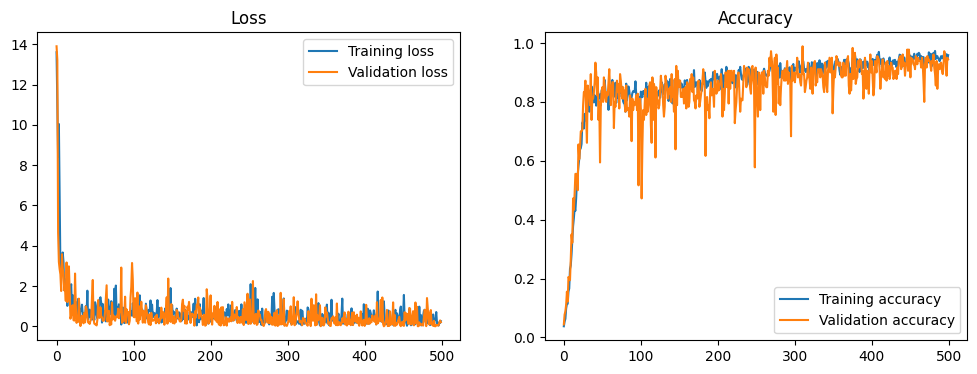

Epoch [501/1100], Loss: 0.8186325430870056, Accuracy: 0.9603174603174603 Correct: 605 Total: 630 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.9166666666666666 Validation loss: 0.2889810800552368 Correct: 165 Total: 180
Epoch [502/1100], Loss: 0.6469906568527222, Accuracy: 0.9476190476190476 Correct: 597 Total: 630 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.9166666666666666 Validation loss: 1.420782208442688 Correct: 165 Total: 180
Epoch [503/1100], Loss: 0.08494947105646133, Accuracy: 0.953968253968254 Correct: 601 Total: 630 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9 Validation loss: 0.08518563210964203 Correct: 162 Total: 180
Epoch [504/1100], Loss: 0.30954650044441223, Accuracy: 0.9619047619047619 Correct: 606 Total: 630 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.95 Validation loss: 0.1800156533718109 Correct: 171 Total: 180
Epoch [505/1100], Loss: 0.074774

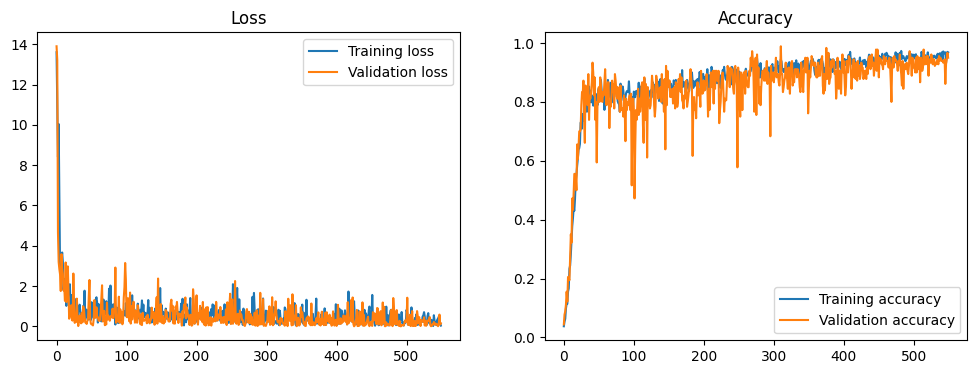

Epoch [551/1100], Loss: 0.39900752902030945, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.9611111111111111 Validation loss: 0.10386437922716141 Correct: 173 Total: 180
Epoch [552/1100], Loss: 0.2155587077140808, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.9111111111111111 Validation loss: 0.4164777100086212 Correct: 164 Total: 180
Epoch [553/1100], Loss: 0.16435830295085907, Accuracy: 0.9555555555555556 Correct: 602 Total: 630 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.9333333333333333 Validation loss: 0.32152920961380005 Correct: 168 Total: 180
Epoch [554/1100], Loss: 0.17219388484954834, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.9333333333333333 Validation loss: 0.1149488240480423 Correct: 168 Total: 180


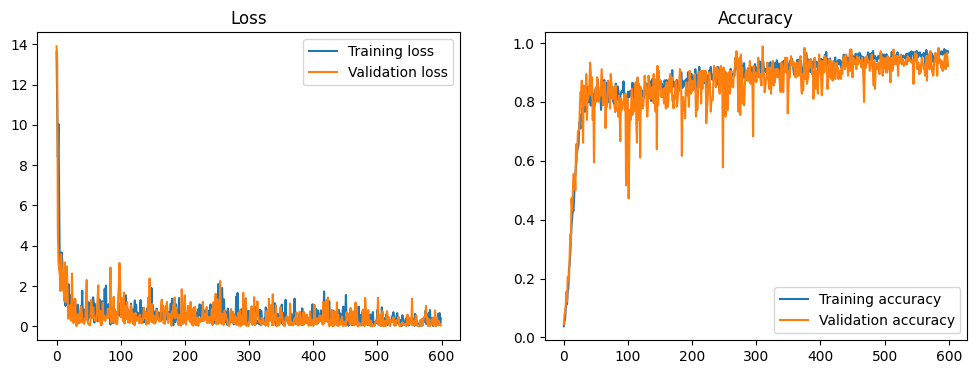

Epoch [601/1100], Loss: 0.0784446969628334, Accuracy: 0.9523809523809523 Correct: 600 Total: 630 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.9611111111111111 Validation loss: 0.3945566415786743 Correct: 173 Total: 180
Epoch [602/1100], Loss: 0.32688745856285095, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.9222222222222223 Validation loss: 0.4754088521003723 Correct: 166 Total: 180
Epoch [603/1100], Loss: 0.4843241274356842, Accuracy: 0.9412698412698413 Correct: 593 Total: 630 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.9444444444444444 Validation loss: 0.061288293451070786 Correct: 170 Total: 180
Epoch [604/1100], Loss: 0.1616927534341812, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9388888888888889 Validation loss: 0.42316335439682007 Correct: 169 Total: 180

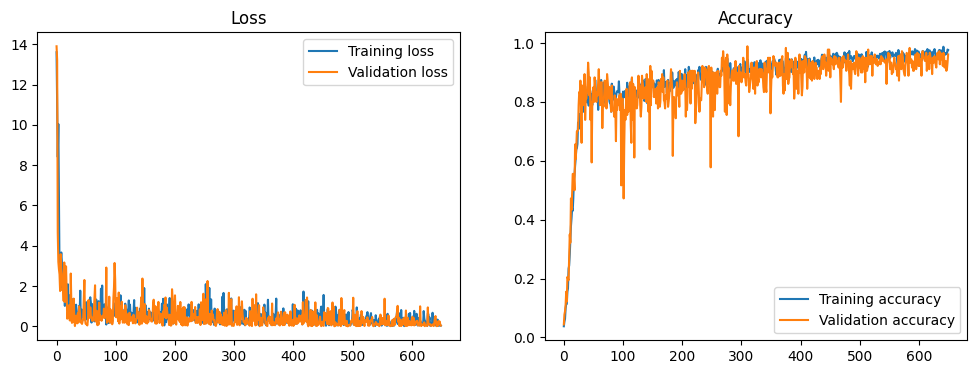

Epoch [651/1100], Loss: 0.06024380400776863, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9388888888888889 Validation loss: 0.4677221179008484 Correct: 169 Total: 180
Epoch [652/1100], Loss: 0.03291136398911476, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.95 Validation loss: 0.22783955931663513 Correct: 171 Total: 180
Epoch [653/1100], Loss: 0.2723068296909332, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9555555555555556 Validation loss: 0.19839005172252655 Correct: 172 Total: 180
Epoch [654/1100], Loss: 0.15036910772323608, Accuracy: 0.9603174603174603 Correct: 605 Total: 630 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.9666666666666667 Validation loss: 0.019900497049093246 Correct: 174 Total: 180
Epoch [655/1

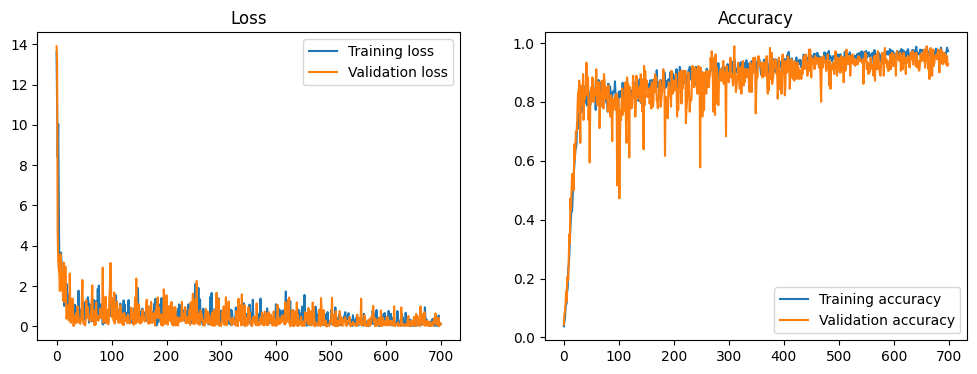

Epoch [701/1100], Loss: 0.04555724933743477, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9555555555555556 Validation loss: 0.07015331089496613 Correct: 172 Total: 180
Epoch [702/1100], Loss: 0.07663453370332718, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9611111111111111 Validation loss: 0.0922914445400238 Correct: 173 Total: 180
Epoch [703/1100], Loss: 0.31791651248931885, Accuracy: 0.9793650793650793 Correct: 617 Total: 630 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9388888888888889 Validation loss: 0.10010546445846558 Correct: 169 Total: 180
Epoch [704/1100], Loss: 0.2058076411485672, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9722222222222222 Validation loss: 0.025124821811914444 Correct: 175 Total: 180

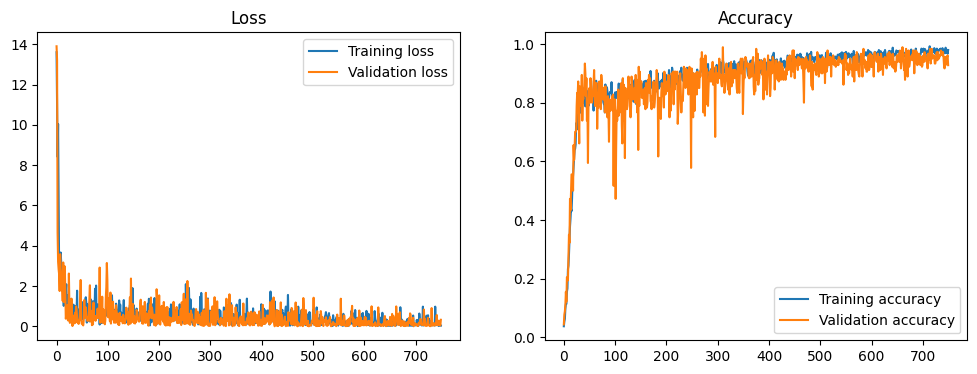

Epoch [751/1100], Loss: 0.3858489990234375, Accuracy: 0.973015873015873 Correct: 613 Total: 630 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9277777777777778 Validation loss: 0.13146910071372986 Correct: 167 Total: 180
Epoch [752/1100], Loss: 0.2855031192302704, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9111111111111111 Validation loss: 0.14883221685886383 Correct: 164 Total: 180
Epoch [753/1100], Loss: 0.31923189759254456, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9166666666666666 Validation loss: 0.290488064289093 Correct: 165 Total: 180
Epoch [754/1100], Loss: 0.07530625909566879, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.9444444444444444 Validation loss: 0.13084878027439117 Correct: 170 Total: 180


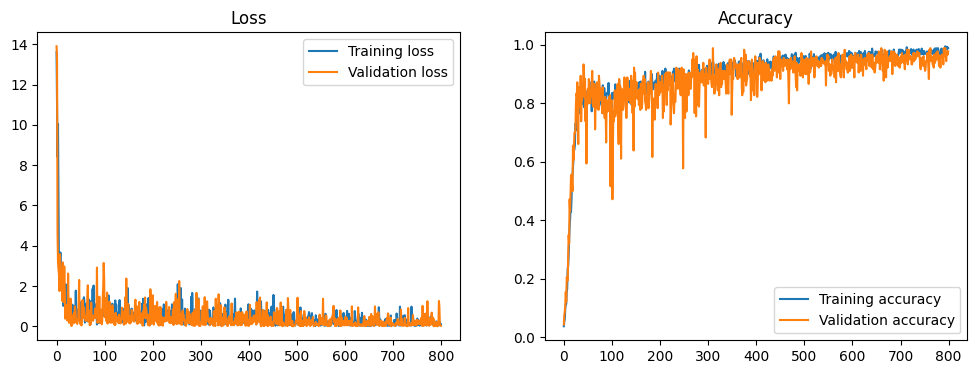

Epoch [801/1100], Loss: 0.2117723822593689, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9555555555555556 Validation loss: 0.02170097455382347 Correct: 172 Total: 180
Epoch [802/1100], Loss: 0.32012268900871277, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9555555555555556 Validation loss: 0.010533172637224197 Correct: 172 Total: 180
Epoch [803/1100], Loss: 0.20575295388698578, Accuracy: 0.9619047619047619 Correct: 606 Total: 630 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9555555555555556 Validation loss: 0.04337729513645172 Correct: 172 Total: 180
Epoch [804/1100], Loss: 0.04861251637339592, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.95 Validation loss: 0.35382193326950073 Correct: 171 Total: 180
Epoch [805/

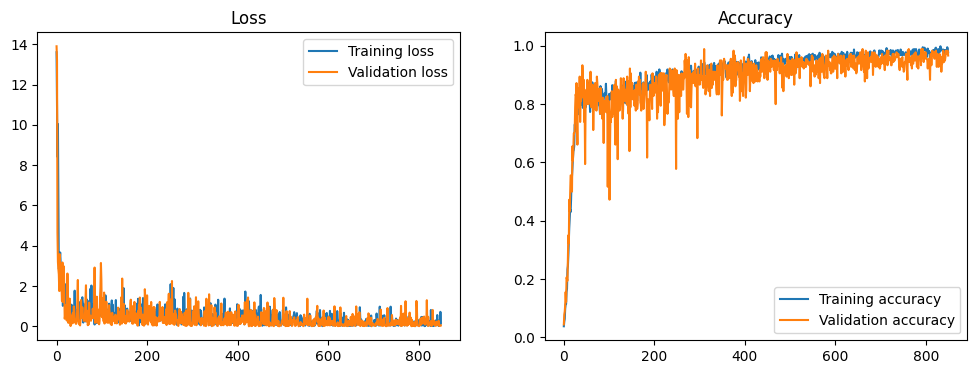

Epoch [851/1100], Loss: 0.016060205176472664, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9722222222222222 Validation loss: 0.047638773918151855 Correct: 175 Total: 180
Epoch [852/1100], Loss: 0.30200979113578796, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9722222222222222 Validation loss: 0.013622628524899483 Correct: 175 Total: 180
Epoch [853/1100], Loss: 0.13102082908153534, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9611111111111111 Validation loss: 0.12119010835886002 Correct: 173 Total: 180
Epoch [854/1100], Loss: 0.031287383288145065, Accuracy: 0.9777777777777777 Correct: 616 Total: 630 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9611111111111111 Validation loss: 0.755526602268219 Correct: 173 To

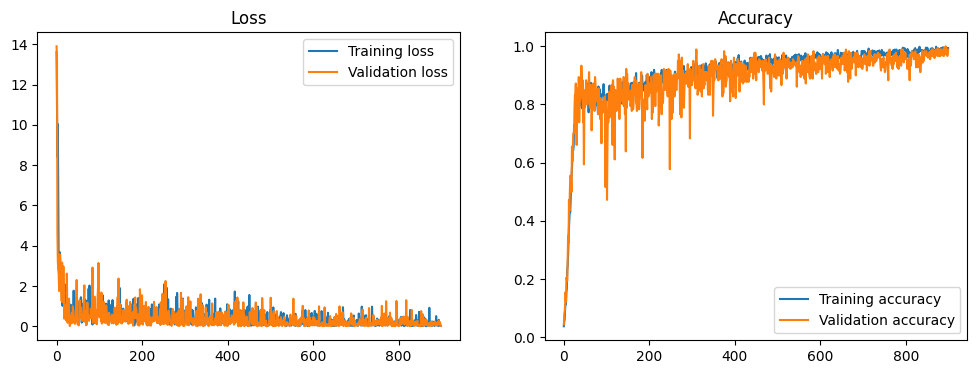

Epoch [901/1100], Loss: 0.19607847929000854, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.11703474819660187 Correct: 174 Total: 180
Epoch [902/1100], Loss: 0.38545843958854675, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.07198398560285568 Correct: 173 Total: 180
Epoch [903/1100], Loss: 0.13452346622943878, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.13295428454875946 Correct: 176 Total: 180
Epoch [904/1100], Loss: 0.5788500905036926, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.12273752689361572 Correct: 177 Total: 180
E

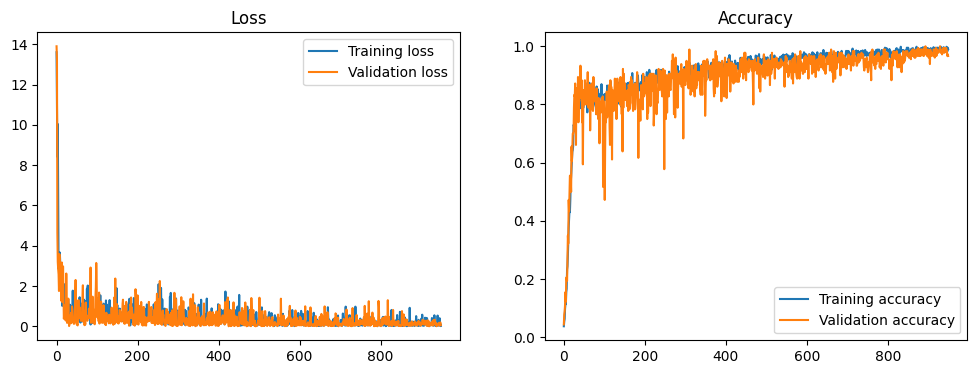

Epoch [951/1100], Loss: 0.05476909503340721, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 0.013015452772378922 Correct: 178 Total: 180
Epoch [952/1100], Loss: 0.1064426377415657, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 0.07343863695859909 Correct: 178 Total: 180
Epoch [953/1100], Loss: 0.18913312256336212, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.20261727273464203 Correct: 179 Total: 180
Epoch [954/1100], Loss: 0.016641831025481224, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.0852070152759552 Correct: 179 Total: 180


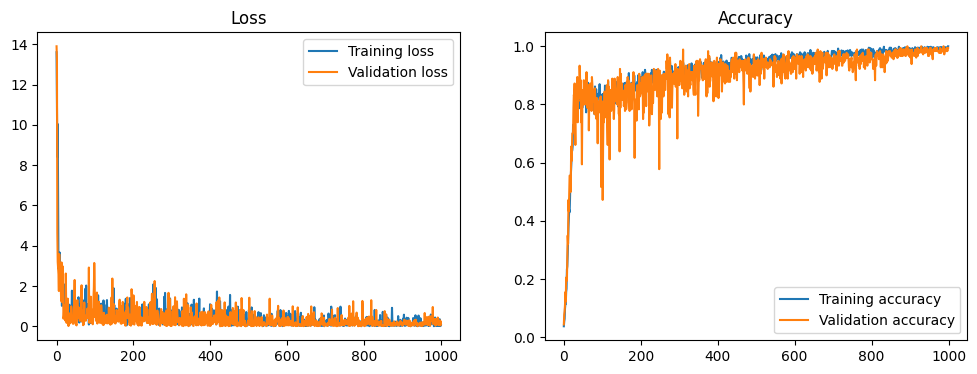

Epoch [1001/1100], Loss: 0.04758599027991295, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.04527631402015686 Correct: 176 Total: 180
Epoch [1002/1100], Loss: 0.19578619301319122, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.3701547384262085 Correct: 179 Total: 180
Epoch [1003/1100], Loss: 0.020290054380893707, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 0.3784037232398987 Correct: 178 Total: 180
Epoch [1004/1100], Loss: 0.051538821309804916, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.0900663211941719 Correct: 176 Total:

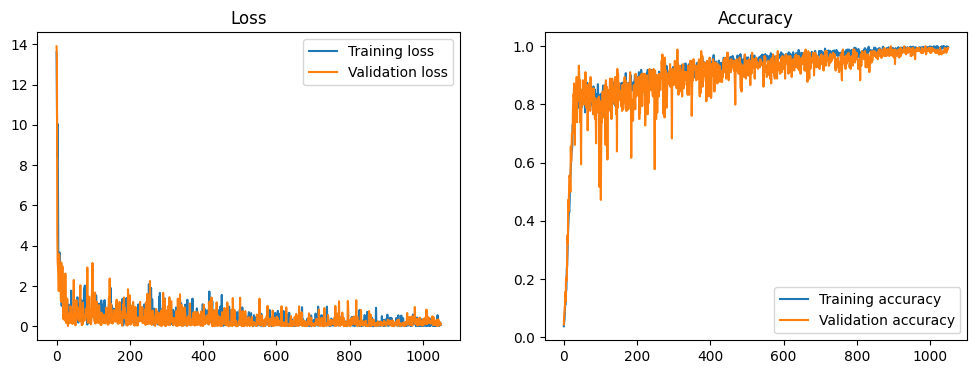

Epoch [1051/1100], Loss: 0.18338654935359955, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.12193135172128677 Correct: 179 Total: 180
Epoch [1052/1100], Loss: 0.027778280898928642, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 0.06770333647727966 Correct: 178 Total: 180
Epoch [1053/1100], Loss: 0.03556002303957939, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.1726781725883484 Correct: 179 Total: 180
Epoch [1054/1100], Loss: 0.04876617714762688, Accuracy: 1.0 Correct: 630 Total: 630 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9944444444444445 Validation loss: 0.0424000583589077 Correct: 179 Total: 180
Epoch 

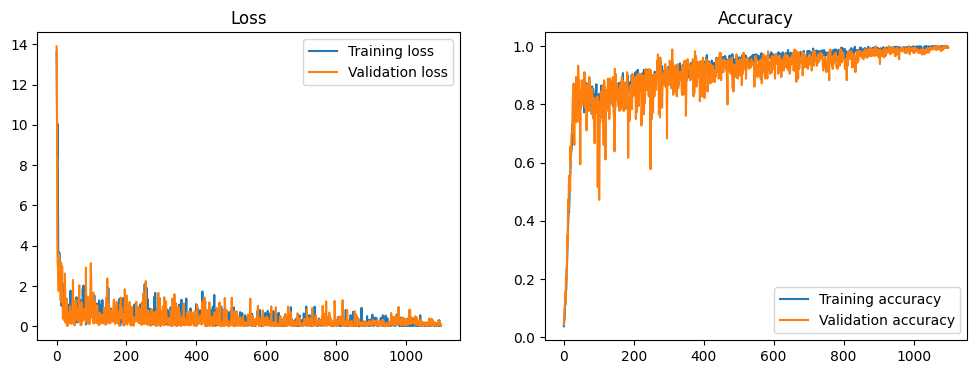

In [27]:
best_model_path = "CoAtNet-1-Best-Zoom.pkl"
model_path = "CoAtNet-1-Zoom.pkl"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [28]:
save_model(model, model_path)

### Results

In [29]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [30]:
print("Best validation acc: ", max(val_accuracies))
print("Last validation acc: ", val_accuracies[-1])

Best validation acc:  1.0
Last validation acc:  0.9944444444444445


In [31]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [32]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-zoom.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

### Test accuracy

In [33]:
cm = predict(test_dataloader)

Test Accuracy: 0.9888888888888889


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
predicted_labels,Z,9,L,X,1,H,B,W,Y,P,S,D,L,I,W,M,0,Y,W,D,6,8,B,7,7,M,B,O,6,X,Q,0,A,F,9,L,5,5,U,Q,L,U,L,N,Z,H,7,Y,N,0,3,K,8,7,2,C,C,O,I,D,4,6,D,B,2,K,R,T,9,T,4,S,B,X,R,Z,S,D,0,1,W,S,V,D,3,5,M,Q,T,8
true_labels,Z,9,L,X,1,H,B,W,Y,P,S,D,L,I,W,M,0,Y,W,D,6,8,B,7,7,M,B,O,6,X,Q,0,A,F,9,L,5,5,U,Q,L,U,L,N,Z,H,7,Y,N,K,3,K,8,7,2,C,C,O,I,D,4,6,D,B,2,K,R,T,9,T,4,S,B,X,R,Z,S,D,0,1,W,S,V,D,3,5,M,Q,T,8


0.9888888888888889
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00         2
        

### Confusion matrix

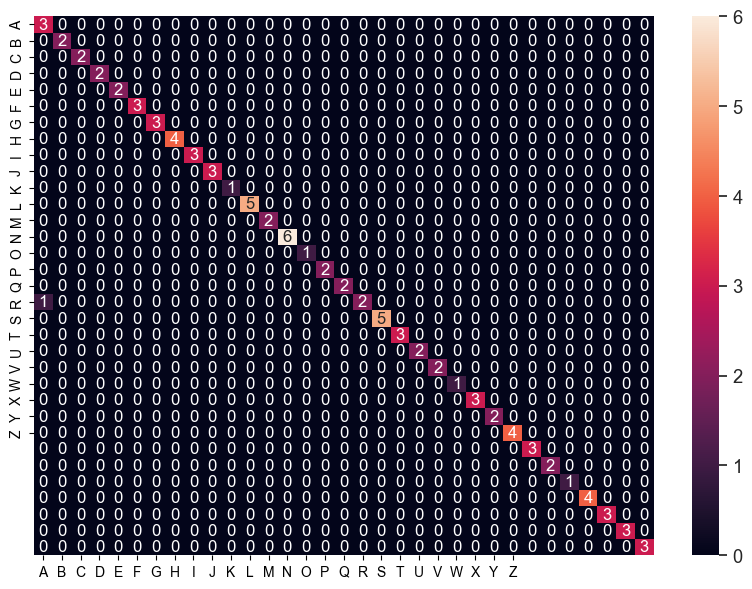

In [34]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=alphabet, 
                yticklabels=alphabet,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1")